In [16]:
import copy

import numpy as np
import pyrallis
import torch
import matplotlib.pyplot as plt


from HAND.HAND_train import load_original_model
from HAND.eval_func import EvalFunction
from HAND.predictors.factory import HANDPredictorFactory, PredictorDataParallel
from HAND.predictors.predictor import HANDPredictorBase
from HAND.tasks.dataloader_factory import DataloaderFactory
from HAND.tasks.model_factory import ModelFactory
from HAND.tasks.pruning.prune_options import PruneConfig
from HAND.tasks.pruning.pruner import Pruner, get_filter_reconstruction_errors
from HAND.permutations import utils as permutations_utils
from HAND.options import TrainConfig

In [17]:
def get_num_zero_weights(weight_list):
    num_zeros = 0
    for layer in weight_list:
        num_zeros += torch.sum(layer == 0)
    return num_zeros


def get_num_weights(weight_list):
    num_weights = 0
    for layer in weight_list:
        num_weights += torch.numel(layer)
    return num_weights

In [25]:
cfg = pyrallis.load(PruneConfig, open("./resnet56_0_B_cifar100_big_permute_l2withreg.yaml", "r"))

In [26]:
use_cuda = not cfg.train_cfg.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


In [27]:
_, test_dataloader = DataloaderFactory.get(cfg.train_cfg.task,
                                           **{'batch_size': cfg.train_cfg.batch_size,
                                              'num_workers': cfg.train_cfg.num_workers})

Files already downloaded and verified


In [28]:
# import original model
original_model, reconstructed_model = load_original_model(cfg.train_cfg, device)


eval_fn = EvalFunction(cfg.train_cfg)

# import predictor
pos_embedding = reconstructed_model.positional_encoder.output_size
predictor = HANDPredictorFactory(cfg.train_cfg, input_size=pos_embedding).get_predictor().to(device)

Trying to load precomputed embeddings
Loaded positional embeddings for layer 1/57
Loaded positional embeddings for layer 2/57
Loaded positional embeddings for layer 3/57
Loaded positional embeddings for layer 4/57
Loaded positional embeddings for layer 5/57
Loaded positional embeddings for layer 6/57
Loaded positional embeddings for layer 7/57
Loaded positional embeddings for layer 8/57
Loaded positional embeddings for layer 9/57
Loaded positional embeddings for layer 10/57
Loaded positional embeddings for layer 11/57
Loaded positional embeddings for layer 12/57
Loaded positional embeddings for layer 13/57
Loaded positional embeddings for layer 14/57
Loaded positional embeddings for layer 15/57
Loaded positional embeddings for layer 16/57
Loaded positional embeddings for layer 17/57
Loaded positional embeddings for layer 18/57
Loaded positional embeddings for layer 19/57
Loaded positional embeddings for layer 20/57
Loaded positional embeddings for layer 21/57
Loaded positional embeddin

In [29]:
predictor.load(cfg.predictor_path)

In [30]:

learnable_weights_shapes = reconstructed_model.get_learnable_weights_shapes()
indices, positional_embeddings = reconstructed_model.get_indices_and_positional_embeddings()

# get original weights and predict reconstructed weights
original_weights = original_model.get_learnable_weights()
reconstructed_weights = HANDPredictorBase.predict_all(predictor, positional_embeddings,
                                                      original_weights,
                                                      learnable_weights_shapes)
reconstructed_model.update_weights(reconstructed_weights)

pruned_model = copy.deepcopy(reconstructed_model)

In [31]:
print('evaluating original model')
eval_fn.eval(original_model, test_dataloader, 0, None, '')
print('evaluating reconstructed model')
eval_fn.eval(reconstructed_model, test_dataloader, 0, None, '')


evaluating original model

 Starting eval on test set.

Test set: Average loss: -17.2330, Accuracy: 9352/10000 (94%)

evaluating reconstructed model

 Starting eval on test set.

Test set: Average loss: -16.9343, Accuracy: 9350/10000 (94%)



93.5

In [32]:
pruned_model = copy.deepcopy(reconstructed_model)
pruner_flip = Pruner(cfg, predictor, reconstructed_model, original_model, pruned_model, device)
pruner_flip.reconstruction_prune(0.5, error_metric='relative')
eval_fn.eval(pruned_model, test_dataloader, 0, None, '')


 Starting eval on test set.

Test set: Average loss: -8.9295, Accuracy: 8703/10000 (87%)



87.03

In [33]:
pruner = Pruner(cfg, predictor, original_model, reconstructed_model, pruned_model, device)

# # relative_nern_pruned_model
# print('unstructured_reconstruction_prune')
# pruner.reconstruction_prune(0.2, error_metric='relative')
# eval_fn.eval(pruned_model, test_dataloader, 0, None, '')

# magnitude_pruned_model
prune_factor=0.1
print('magnitude_prune')
pruner.magnitude_prune(prune_factor)
eval_fn.eval(pruned_model, test_dataloader, 0, None, '')

print('recon_magnitude_prune')
pruner.reconstruction_magnitude_prune(prune_factor)
eval_fn.eval(pruned_model, test_dataloader, 0, None, '')




magnitude_prune

 Starting eval on test set.

Test set: Average loss: -17.2418, Accuracy: 9348/10000 (93%)

recon_magnitude_prune

 Starting eval on test set.

Test set: Average loss: -17.1991, Accuracy: 9343/10000 (93%)



93.43

In [ ]:
pruning_factors = np.linspace(0.1, 0.9, 20)
magnitude_pruned_accuracies = list()
recon_magnitude_orig_pruned_accuracies = list()
recon_magnitude_pruned_accuracies = list()
recon_error_pruned_accuracies = list()

for pruning_factor in pruning_factors:
    pruner.magnitude_prune(pruning_factor)
    magnitude_accuracy = eval_fn.eval(pruned_model, test_dataloader, 0, None, '')
    pruner_flip.magnitude_prune(pruning_factor)
    recon_magnitude_pruned_accuracy = eval_fn.eval(pruned_model, test_dataloader, 0, None, '')
    pruner.reconstruction_magnitude_prune(pruning_factor)
    recon_magnitude_origin_pruned_accuracy = eval_fn.eval(pruned_model, test_dataloader, 0, None, '')
    pruner.reconstruction_prune(pruning_factor, error_metric='relative')
    recon_error_pruned_accuracy = eval_fn.eval(pruned_model, test_dataloader, 0, None, '')
    
    recon_magnitude_orig_pruned_accuracies.append(recon_magnitude_pruned_accuracy)
    magnitude_pruned_accuracies.append(magnitude_accuracy)
    recon_magnitude_pruned_accuracies.append(recon_magnitude_origin_pruned_accuracy)
    recon_error_pruned_accuracies.append(recon_error_pruned_accuracy)

In [ ]:
pruning_factors = np.linspace(0.1, 0.9, 20)
recon_error_recon_pruned_accuracies = list()
for pruning_factor in pruning_factors:
    pruner_flip.reconstruction_prune(pruning_factor, error_metric='relative')
    recon_error_recon_pruned_accuracy = eval_fn.eval(pruned_model, test_dataloader, 0, None, '')
    
    recon_error_recon_pruned_accuracies.append(recon_error_recon_pruned_accuracy)


In [ ]:
pruning_factors

In [ ]:

plt.plot(pruning_factors, recon_magnitude_orig_pruned_accuracies, label='recon_magnitude_orig')
plt.plot(pruning_factors, magnitude_pruned_accuracies, label='magnitude')
plt.plot(pruning_factors, recon_magnitude_pruned_accuracies, label='recon_magnitude')
# plt.plot(pruning_factors, recon_error_pruned_accuracies, label='recon_error')
# plt.plot(pruning_factors, recon_error_recon_pruned_accuracies, label='recon_error_recon')

plt.legend()
plt.xlabel('Pruning Factors')
plt.ylabel('Pruned Models Accuracies')
plt.title('93% Reconstruction')
plt.xlim(0.5,0.9)
# plt.ylim(60,100)
# plt.xlim(0.2,0.7)
plt.show()

In [ ]:

# plt.plot(pruning_factors, np.array(recon_magnitude_orig_pruned_accuracies)/100, label='recon_magnitude_orig')
# plt.plot(pruning_factors, np.array(magnitude_pruned_accuracies)/100, label='magnitude')
plt.plot(pruning_factors, (np.array(magnitude_pruned_accuracies)-np.array(recon_magnitude_orig_pruned_accuracies)), label='diff')
# plt.plot(pruning_factors, np.array(recon_magnitude_pruned_accuracies)/100, label='recon_magnitude')


plt.legend()
plt.xlabel('Pruning Factors')
plt.ylabel('Pruned Models Accuracies')
plt.title('93% Reconstruction')
plt.xlim(0,1)
plt.yscale("linear")
# plt.ylim(60,100)
plt.xlim(0.4,1)
plt.show()

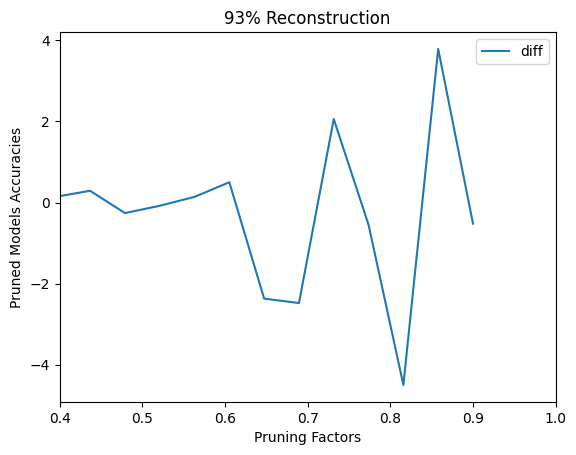

In [58]:

# plt.plot(pruning_factors, np.array(recon_magnitude_orig_pruned_accuracies)/100, label='recon_magnitude_orig')
# plt.plot(pruning_factors, np.array(magnitude_pruned_accuracies)/100, label='magnitude')
plt.plot(pruning_factors, (np.array(magnitude_pruned_accuracies)-np.array(recon_magnitude_orig_pruned_accuracies)), label='diff')
# plt.plot(pruning_factors, np.array(recon_magnitude_pruned_accuracies)/100, label='recon_magnitude')


plt.legend()
plt.xlabel('Pruning Factors')
plt.ylabel('Pruned Models Accuracies')
plt.title('93% Reconstruction')
plt.xlim(0,1)
plt.yscale("linear")
# plt.ylim(60,100)
plt.xlim(0.4,1)
plt.show()

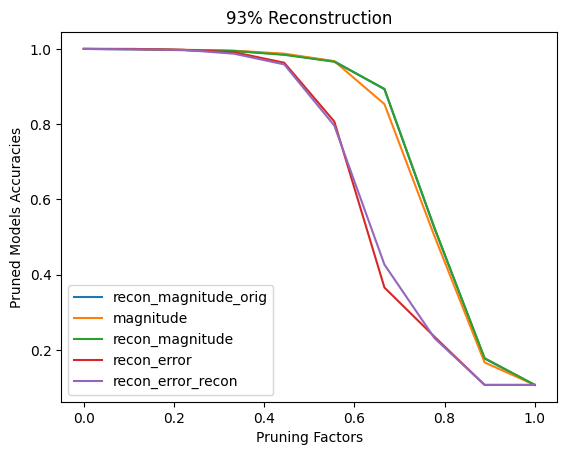

In [38]:

plt.plot(pruning_factors, np.array(recon_magnitude_orig_pruned_accuracies) / recon_magnitude_orig_pruned_accuracies[0], label='recon_magnitude_orig')
plt.plot(pruning_factors, np.array(magnitude_pruned_accuracies) / magnitude_pruned_accuracies[0], label='magnitude')
plt.plot(pruning_factors, np.array(recon_magnitude_pruned_accuracies) / recon_magnitude_pruned_accuracies[0], label='recon_magnitude')
plt.plot(pruning_factors, np.array(recon_error_pruned_accuracies) / recon_error_pruned_accuracies[0], label='recon_error')
plt.plot(pruning_factors, np.array(recon_error_recon_pruned_accuracies) / recon_error_recon_pruned_accuracies[0], label='recon_error_recon')

plt.legend()
plt.xlabel('Pruning Factors')
plt.ylabel('Pruned Models Accuracies')
plt.title('93% Reconstruction')
# plt.xlim(0.2,0.7)
# plt.ylim(60,100)
# plt.xlim(0.2,0.7)
plt.show()

In [ ]:
def prune_predictor(factor):
    pruned_predictor = copy.deepcopy(predictor)
    with torch.no_grad():
        parameters=list(predictor.parameters())
        pruned_weights = copy.deepcopy(parameters)
        all_sorted, all_sorted_idx = torch.sort(torch.cat([torch.abs(t.view(-1)) for t in pruned_weights]))
        cum_num_elements = torch.cumsum(torch.tensor([t.numel() for t in pruned_weights]), dim=0)
        cum_num_elements = torch.cat([torch.tensor([0]), cum_num_elements])

        n = int(cum_num_elements[-1].item() * pruning_factor)

        split_indices_lt = [all_sorted_idx[:n] < cum_num_elements[i + 1] for i, _ in enumerate(cum_num_elements[1:])]
        split_indices_ge = [all_sorted_idx[:n] >= cum_num_elements[i] for i, _ in enumerate(cum_num_elements[:-1])]
        prune_indices = [all_sorted_idx[:n][torch.logical_and(lt, ge)] - c for lt, ge, c in
                         zip(split_indices_lt, split_indices_ge, cum_num_elements[:-1])]
        for p, i in zip(pruned_predictor.parameters(), prune_indices):
            if len(p.shape)==2:
                p.view(-1)[i] = 0
    return pruned_predictor

In [290]:
pruned_predictor = prune_predictor(0.1)
reconstructed_model_1 = copy.deepcopy(reconstructed_model)
reconstructed_weights = HANDPredictorBase.predict_all(pruned_predictor, positional_embeddings,
                                                      original_weights,
                                                      learnable_weights_shapes)
reconstructed_model_1.update_weights(reconstructed_weights)

pruned_predictor_2 = prune_predictor(0.02)
reconstructed_model_2 = copy.deepcopy(reconstructed_model)
reconstructed_weights = HANDPredictorBase.predict_all(pruned_predictor, positional_embeddings,
                                                      original_weights,
                                                      learnable_weights_shapes)
reconstructed_model_2.update_weights(reconstructed_weights)

In [292]:
pruned_model = copy.deepcopy(reconstructed_model)
pruner_1 = Pruner(cfg, predictor, reconstructed_model, reconstructed_model_1, pruned_model, device)
pruner_1.reconstruction_prune(0.7, error_metric='relative')
eval_fn.eval(pruned_model, test_dataloader, 0, None, '')


 Starting eval on test set.

Test set: Average loss: -0.4876, Accuracy: 1406/10000 (14%)



14.06

In [289]:
pruner_2 = Pruner(cfg, predictor, reconstructed_model, reconstructed_model_2, pruned_model, device)
pruner_2.reconstruction_prune(0.2, error_metric='relative')
eval_fn.eval(pruned_model, test_dataloader, 0, None, '')


 Starting eval on test set.

Test set: Average loss: -16.8127, Accuracy: 9287/10000 (93%)



92.87